In [1]:
import sys
sys.path.append('../../..')
import qusim.DataPlot.plot_lib as pl
import qusim.Instruments.tools as tools
import qusim.Instruments.stochastic_gen as sg
import qusim.System.arb_qubit_system as aqs
import qusim.Instruments.angle as  ang
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from time import *
from sympy import*
import copy
import pickle
from qutip import*
from scipy.stats import sem
def var_name2str(variable):
    def nested_var_name2str(value):
        if isinstance(value, list):
            return [nested_var_name2str(item) for item in value]
        else:
            for name in globals():
                if eval(name) == value:
                    return name
            return str(value)
    return nested_var_name2str(variable)
%load_ext autoreload
%autoreload 2 

In [136]:
freq_list = [ # GHz
    [0, 10.25],
    [0, 10]
]
inter_list = [
    [{
        "v01": 0,
        "v00": 1,
        "v11": -1
    },
    {
        "v01": 0,
        "v00": 1,
        "v11": -1
    }],
    [{
        "v01": 1,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": 1,
        "v00": 0,
        "v11": 0
    }]
    ,
    [{
        "v01": -1j,
        "v00": 0,
        "v11": 0
    },
    {
        "v01": -1j,
        "v00": 0,
        "v11": 0
    }]
]
r_dic = {
    "r12": 1e-3
}
r = tools.r2matrix(r_dic, freq_list) 
extra_list=None
driving_list = [
    {
        "W01": 1j
    },
    {
        "W01": 1j
    }
]
bias_list = [ 
    {
        "Z11": 1
    },
    {
        "Z11": 1
    }
]
# gamma_list = [{"z":1/200}, {"z": 1/200}]
gamma_list = None
_system_arb1 = aqs.arb_qubit_system(freq_list, inter_list, extra_list=extra_list, r =r, driving_list=driving_list, bias_list=bias_list)

# System initial state & eigenstate
state_00, E_00, _= _system_arb1.get_eigenstates_energy((0,0))
state_10, E_10, _= _system_arb1.get_eigenstates_energy((1,0))
state_01, E_01, _= _system_arb1.get_eigenstates_energy((0,1))
state_11, E_11, _= _system_arb1.get_eigenstates_energy((1,1))

# spin basis
state_uu = state_11
state_dd = state_00
state_ud = Qobj(np.array([0,0,1,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)
state_du = Qobj(np.array([0,1,0,0]), dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket)

# ST0
state_S = (state_ud-state_du)/np.sqrt(2)
state_T0 = (state_ud+state_du)/np.sqrt(2)

_system_arb1.H

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[6.28318531e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 5.02591993e+01 1.25663706e-02 0.00000000e+00]
 [0.00000000e+00 1.25663706e-02 6.43963662e+01 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.14674415e+02]]

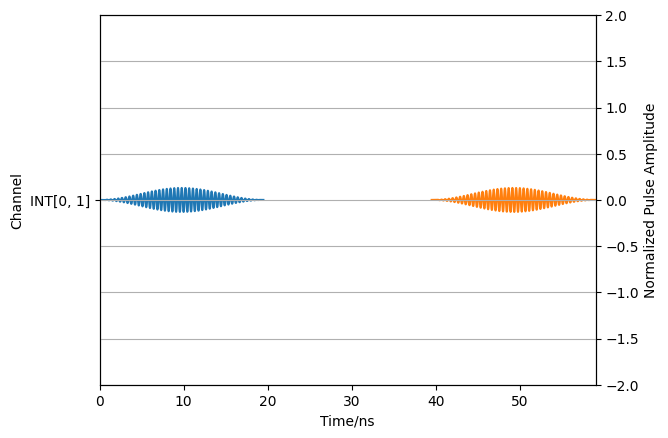

0

In [138]:
tg = 19.5; tau = 20
t_total = 2*tg+tau
omega_d= freq_list[0][1] - freq_list[1][1]
simulation_option = {
    "simulation_time": t_total, # ns
    "simulation_step": int(t_total)*100,
    "initial_state": [state_ud] # Do multiple simulation
}
pulse_sequence = [
    {
        'pulse_index': 0,
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': 0,
        't_width': tg, 
        't_plateau':0 ,
        'freq': omega_d, 
        'phase': 0, 
        'amplitude': 1.3e-2,
        'q_index': [0,1]
    },
    {
        'pulse_index': 1,
        'type': "INT",
        'pulse_shape': "cosine",
        't_delay': tg+tau, 
        't_width': tg, 
        't_plateau':0 , 
        'freq': omega_d, 
        'phase': np.pi,
        'amplitude': 1.3e-2,
        'q_index': [0,1]
    }
]
%matplotlib inline
pl.plot_pulse_sequence(pulse_sequence, simulation_option)

In [139]:
result_list, angle_list = _system_arb1.system_dynamics_mesolve(simulation_option, pulse_sequence)

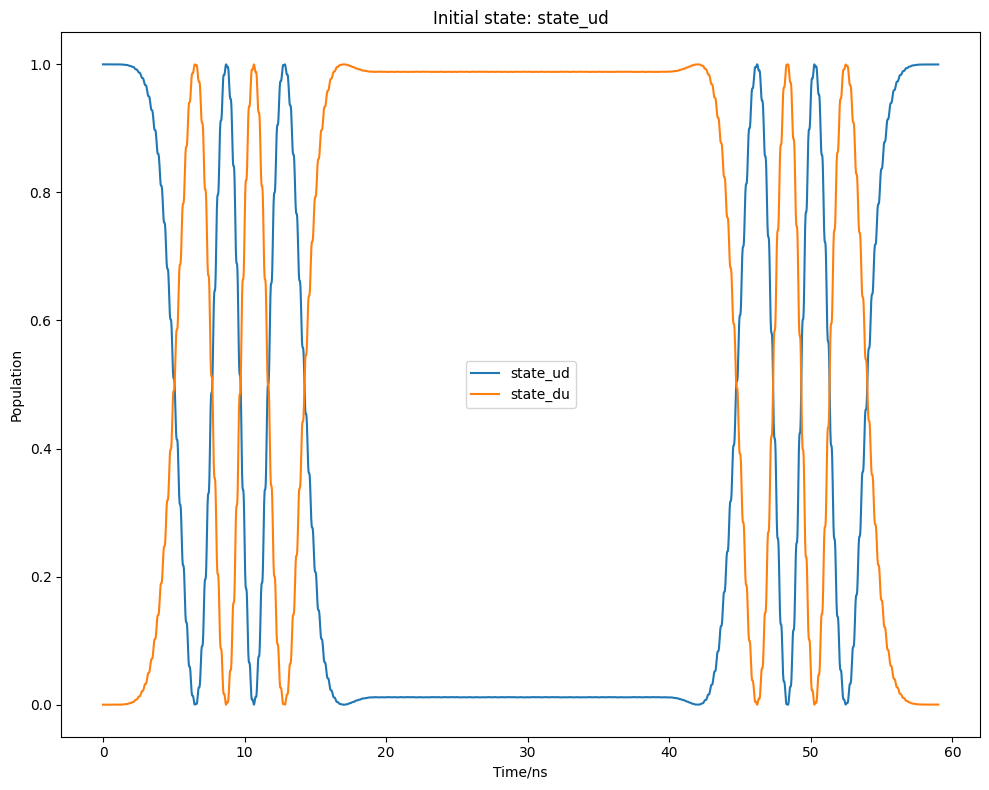

0

In [140]:
interested_state = [
                    [state_ud,state_du]
                    ]
interested_state_label = var_name2str(interested_state)
initial_state_label = var_name2str(simulation_option["initial_state"])

%matplotlib inline
pl.plot_population_evolution(_system_arb1, result_list, simulation_option, interested_state, interested_state_label, initial_state_label)